In [1]:
# This notebook runs from the projects root directory.
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

Current working directory: c:\Users\pavan\Desktop\senior_project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import pickle
from stable_baselines3 import DQN, A2C, PPO, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv
from environments.discrete_env_v4 import PortfolioManagementEnv

In [3]:
experiment_id = f'EXPERIMENT_2_8_{int(time.time())}'
print(experiment_id)

EXPERIMENT_2_8_1679049991


In [4]:
models_dir = f'experiments_2/models/{experiment_id}'
log_dir = f'experiments_2/logs'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [5]:
train_df = pd.read_csv('data\\asset_classes_stationary_features_train.csv', index_col=0, parse_dates=True)
val_df = pd.read_csv('data\\asset_classes_stationary_features_val.csv', index_col=0, parse_dates=True)

ASSET_CLASSES = ['LARGE_CAP', 'SMALL_CAP', 'BONDS', 'CASH', 'REAL_ESTATE', 'COMMODITIES', 'GOLD']
FEATURES = ['RETURN_12', 'RETURN_26', 'RETURN_60', 'STD_20', 'STD_10']

RETURN_COLS = [asset_class for asset_class in ASSET_CLASSES]
FEATURE_COLS = [f'{asset_class}_{feature}' for asset_class in ASSET_CLASSES for feature in FEATURES]

In [6]:
WINDOW_SIZE = 40
EPISODE_LENGTH = 225
ALLOCATIONS_IN_OBS = True
DRAWDOWN_PENALTY_FACTOR = 0.01

In [7]:
train_env = PortfolioManagementEnv(
    train_df, 
    RETURN_COLS, 
    FEATURE_COLS, 
    window_size=WINDOW_SIZE,
    episode_length=EPISODE_LENGTH,
    allocations_in_obs=True,
    drawdown_penalty_factor=DRAWDOWN_PENALTY_FACTOR,
)

val_env = PortfolioManagementEnv(
    val_df, 
    RETURN_COLS, 
    FEATURE_COLS, 
    window_size=WINDOW_SIZE,
    episode_length=-1,
    allocations_in_obs=True,
    drawdown_penalty_factor=DRAWDOWN_PENALTY_FACTOR,
)

In [8]:
model = DQN(
    'MlpPolicy',
    train_env,
    verbose=1,
    tensorboard_log=log_dir,
    seed=5,
    learning_rate=0.0003,
    batch_size=64,
    exploration_fraction=1.03,
    buffer_size=100_000
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [9]:
def evaluate_model(model, env):

    obs, done = env.reset(), False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)

    values = env.get_portfolio_values()

    annualized_mean_return = values.pct_change(1).mean() * 252
    max_drawdown = abs((values / values.expanding(min_periods=1).max() - 1).min())
    calmar_ratio = annualized_mean_return / max_drawdown

    return calmar_ratio, values

In [10]:
evaluations = {}

TIMESTEPS = 10_000 # number of timesteps between saves
for i in range(1,150):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=experiment_id)
    model.save(f'{models_dir}/{TIMESTEPS*i}')
    evaluations[TIMESTEPS*i] = evaluate_model(model, val_env)

Logging to experiments_2/logs\EXPERIMENT_2_8_1679049991_0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 225      |
|    ep_rew_mean      | 117      |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6117     |
|    time_elapsed     | 0        |
|    total_timesteps  | 900      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 225      |
|    ep_rew_mean      | 116      |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6967     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1800     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 225      |
|    ep_rew_mean      | 116      |
|    exploration_rate | 0.751   

In [11]:
with open(f'evaluations_{experiment_id}.pickle', 'wb') as handle:
    pickle.dump(evaluations, handle, protocol=pickle.HIGHEST_PROTOCOL)

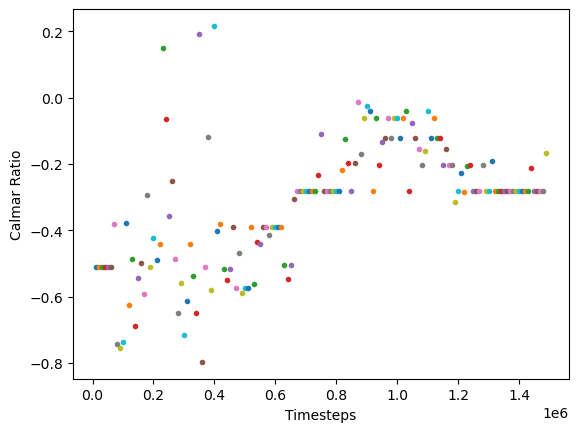

In [12]:
for i in range(1,150):
    plt.plot(TIMESTEPS*i, evaluations[TIMESTEPS*i][0], marker='.')
plt.xlabel('Timesteps');
plt.ylabel('Calmar Ratio');

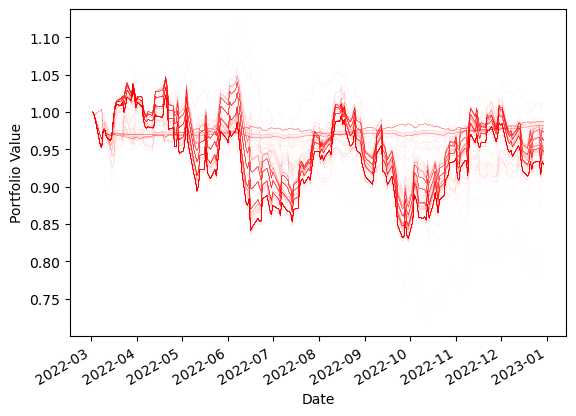

In [15]:
for i in range(1,150):
    plt.plot(evaluations[TIMESTEPS*i][1], alpha=TIMESTEPS*i/1_500_000, color='red', lw=0.1)
plt.gcf().autofmt_xdate();
plt.xlabel('Date');
plt.ylabel('Portfolio Value');